## 作業

請比較使用 l1, l1_l2 及不同比例下的訓練結果

## 參考資料

[Regularization in Machine Learning](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a)

[A geometric perspective on regularization](http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/)

[\[學習筆記\] 機器學習: 正規化 (Machine learning: Regularization)](https://murphymind.blogspot.com/2017/05/machine.learning.regularization.html)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from keras.regularizers import l1, l1_l2
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def train_models(X_train, y_train, X_test, y_test, regularizer_clz, regularizer_params, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=256, momentum=0.95, learning_rate=1e-3):
    train_histories = []
    for i, regularizer_param in enumerate(regularizer_params):
        print('Experiment with {} regularizer: {}'.format(
            regularizer_clz.__name__, ', '.join(['{} = {:.1E}'.format(k, v) for k, v in regularizer_param.items()])))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], y_train.shape[-1], neuron_numbers, regularizer_clz, regularizer_param)
        model.summary()
        model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, regularizer_clz, regularizer_param):
    main_input = hidden_input = Input(shape=input_shape, name='main_input')
    for i, neuron_number in enumerate(neuron_numbers):
        hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}',
                             kernel_regularizer=regularizer_clz(**regularizer_param))(hidden_input)
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, regularizer_params):
    plt.figure(figsize=(8, 6,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], regularizer_params[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, regularizer_param):
    label = ', '.join(['{}={:.1E}'.format(k, v) for k, v in regularizer_param.items()])
    plt.plot(train_history.history[train_name], '-', label='exp: {}'.format(label), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp: {}'.format(label), color=color)

## 使用 L1 正規化在不同比例下觀看學習曲線的走勢

In [7]:
# 設定超參數
regularizer_clz = l1
regularizer_params = [{'l': ratio} for ratio in (1e-2, 1e-4, 1e-8, 1e-12,)]

# 設定繪圖參數
colors = ['r', 'g', 'b', 'y']

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, regularizer_clz, regularizer_params)

Experiment with l1 regularizer: l = 1.0E-02
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 14s - loss: 198.6202 - a

Epoch 22/50
 - 13s - loss: 4.0202 - acc: 0.5533 - val_loss: 4.1027 - val_acc: 0.5139
Epoch 23/50
 - 13s - loss: 3.9559 - acc: 0.5548 - val_loss: 4.0639 - val_acc: 0.5082
Epoch 24/50
 - 13s - loss: 3.8929 - acc: 0.5616 - val_loss: 3.9780 - val_acc: 0.5137
Epoch 25/50
 - 13s - loss: 3.8321 - acc: 0.5655 - val_loss: 4.0032 - val_acc: 0.4918
Epoch 26/50
 - 13s - loss: 3.7722 - acc: 0.5689 - val_loss: 3.8700 - val_acc: 0.5174
Epoch 27/50
 - 13s - loss: 3.7117 - acc: 0.5730 - val_loss: 3.8186 - val_acc: 0.5165
Epoch 28/50
 - 13s - loss: 3.6581 - acc: 0.5748 - val_loss: 3.9100 - val_acc: 0.4827
Epoch 29/50
 - 13s - loss: 3.6003 - acc: 0.5799 - val_loss: 3.7557 - val_acc: 0.5163
Epoch 30/50
 - 13s - loss: 3.5442 - acc: 0.5836 - val_loss: 3.8925 - val_acc: 0.4629
Epoch 31/50
 - 13s - loss: 3.4919 - acc: 0.5835 - val_loss: 3.6365 - val_acc: 0.5150
Epoch 32/50
 - 13s - loss: 3.4347 - acc: 0.5913 - val_loss: 3.5542 - val_acc: 0.5359
Epoch 33/50
 - 13s - loss: 3.3834 - acc: 0.5919 - val_loss: 3.536

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 14s - loss: 2.0383 - acc: 0.2713 - val_loss: 1.8650 - val_acc: 0.3515
Epoch 2/50
 - 13s - loss: 1.7991 - acc: 0.3694 - val_loss: 1.7487 - val_acc: 0.3867
Epoch 3/50
 - 13s - loss: 1.7193 - acc: 0.4005 - val_loss: 1.6973 - val_acc: 0.4052
Epoch 4/50
 - 13s - loss: 1.6645 - acc: 0.4199 - val_loss: 1.6423 - val_acc: 0.4261
Epoch 5/50
 - 13s - loss: 1.6164 - acc: 0.4361 - val_loss: 1.6050 - val_acc: 0.4329
Epoch 6/50
 - 13s - loss: 1.5745 - acc: 0.4511 - val_loss: 1.5729 - val_acc: 0.4473
Epoch 7/50
 - 13s - loss: 1.5395 - acc: 0.4650 - val_loss: 1.5569 - val_acc: 0.4485
Epoch 8/50
 - 13s - loss: 1.5088 - acc: 0.4732 - val_loss: 1.5220 - val_acc: 0.4635
Epoch 9/50
 - 13s - loss: 1.4806 - acc: 0.4809 - val_loss: 1.5047 - val_acc: 0.4687
Epoch 10/50
 - 13s - loss: 1.4552 - acc: 0.4909 - val_loss: 1.4838 - val_acc: 0.4733
Epoch 11/50
 - 13s - loss: 1.4301 - acc: 0.4994 - val_loss: 1.4759 - val_acc: 0.4760
Epoch 12/50
 - 13s - los

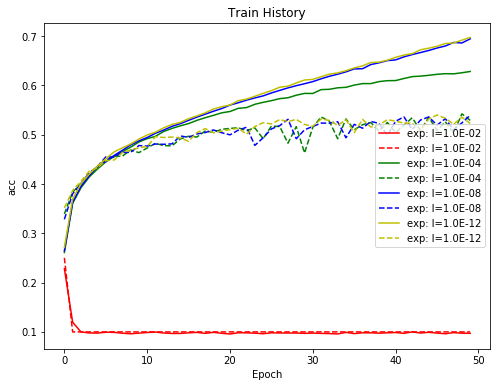

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, regularizer_params)

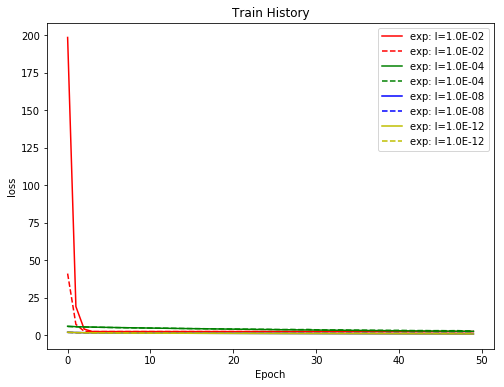

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, regularizer_params)

## 使用 L1L2 正規化在不同比例下觀看學習曲線的走勢

In [11]:
def make_l1l2_mesh_params(ratios):
    l1_ratios, l2_ratios = np.meshgrid(ratios, ratios)
    l1_ratios, l2_ratios = l1_ratios.reshape((-1,)), l2_ratios.reshape((-1,))
    print(l1_ratios)
    print(l2_ratios)
    return [{'l1': l1_ratios[i], 'l2': l2_ratios[i]} for i in range(len(ratios) ** 2)]

In [12]:
# 設定超參數
regularizer_clz = l1_l2
regularizer_params = make_l1l2_mesh_params((1e-8, 1e-12,))

# 設定繪圖參數
colors = ['r', 'g', 'b', 'y']

[1.e-08 1.e-12 1.e-08 1.e-12]
[1.e-08 1.e-08 1.e-12 1.e-12]


In [13]:
train_histories = train_models(X_train, y_train, X_test, y_test, regularizer_clz, regularizer_params)

Experiment with l1_l2 regularizer: l1 = 1.0E-08, l2 = 1.0E-08
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 16s - 

Epoch 22/50
 - 15s - loss: 1.2343 - acc: 0.5663 - val_loss: 1.3620 - val_acc: 0.5188
Epoch 23/50
 - 15s - loss: 1.2204 - acc: 0.5700 - val_loss: 1.3745 - val_acc: 0.5151
Epoch 24/50
 - 15s - loss: 1.2054 - acc: 0.5737 - val_loss: 1.3639 - val_acc: 0.5164
Epoch 25/50
 - 15s - loss: 1.1915 - acc: 0.5801 - val_loss: 1.3816 - val_acc: 0.5202
Epoch 26/50
 - 15s - loss: 1.1780 - acc: 0.5849 - val_loss: 1.3639 - val_acc: 0.5144
Epoch 27/50
 - 15s - loss: 1.1655 - acc: 0.5902 - val_loss: 1.3854 - val_acc: 0.5121
Epoch 28/50
 - 15s - loss: 1.1521 - acc: 0.5945 - val_loss: 1.3598 - val_acc: 0.5174
Epoch 29/50
 - 15s - loss: 1.1348 - acc: 0.6004 - val_loss: 1.3822 - val_acc: 0.5109
Epoch 30/50
 - 15s - loss: 1.1244 - acc: 0.6044 - val_loss: 1.3566 - val_acc: 0.5204
Epoch 31/50
 - 15s - loss: 1.1091 - acc: 0.6086 - val_loss: 1.3454 - val_acc: 0.5266
Epoch 32/50
 - 15s - loss: 1.0967 - acc: 0.6126 - val_loss: 1.3576 - val_acc: 0.5266
Epoch 33/50
 - 15s - loss: 1.0846 - acc: 0.6192 - val_loss: 1.359

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 16s - loss: 2.0343 - acc: 0.2739 - val_loss: 1.8682 - val_acc: 0.3478
Epoch 2/50
 - 15s - loss: 1.8118 - acc: 0.3638 - val_loss: 1.7678 - val_acc: 0.3752
Epoch 3/50
 - 15s - loss: 1.7315 - acc: 0.3930 - val_loss: 1.7065 - val_acc: 0.4019
Epoch 4/50
 - 15s - loss: 1.6727 - acc: 0.4150 - val_loss: 1.6587 - val_acc: 0.4150
Epoch 5/50
 - 15s - loss: 1.6252 - acc: 0.4330 - val_loss: 1.6140 - val_acc: 0.4320
Epoch 6/50
 - 15s - loss: 1.5838 - acc: 0.4466 - val_loss: 1.5776 - val_acc: 0.4433
Epoch 7/50
 - 15s - loss: 1.5473 - acc: 0.4594 - val_loss: 1.5533 - val_acc: 0.4544
Epoch 8/50
 - 15s - loss: 1.5182 - acc: 0.4658 - val_loss: 1.5297 - val_acc: 0.4547
Epoch 9/50
 - 15s - loss: 1.4890 - acc: 0.4770 - val_loss: 1.5112 - val_acc: 0.4649
Epoch 10/50
 - 15s - loss: 1.4626 - acc: 0.4884 - val_loss: 1.4936 - val_acc: 0.4672
Epoch 11/50
 - 15s - loss: 1.4391 - acc: 0.4953 - val_loss: 1.4714 - val_acc: 0.4769
Epoch 12/50
 - 15s - los

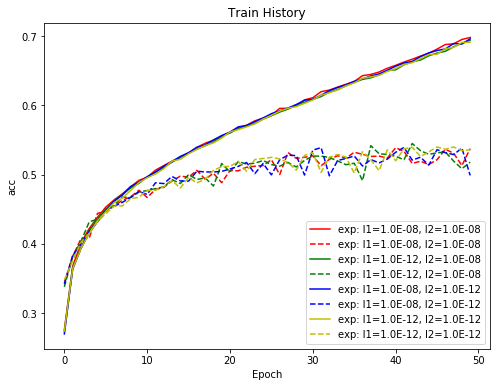

In [14]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, regularizer_params)

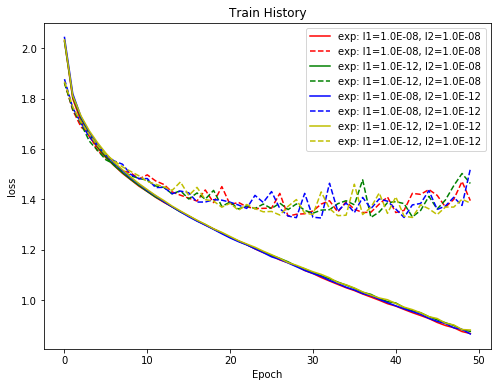

In [15]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, regularizer_params)